In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import lib.models as architectures
import lib.datasets as datasets
import matplotlib.pyplot as plt

### Some variables to set

In [2]:
data_path = '/home/martin/smartestmirror/data/our_faces/'
model_name = 'CAE'
optimizer = 'ADAM'
model_path = 'runs/first_CAE_model/model_best.pth.tar'
batch_size = 225
patch_size = 96
batch_norm = 1e-3
learning_rate = 1e-3
momentum = 0.9
weight_decay = 5e-4

### Check for GPU

In [3]:
# Check whether GPU is available and can be used
# if CUDA is found then set flag to True
is_gpu = torch.cuda.is_available()

### Dataset loader

In [4]:
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

class DATASET:

    def __init__(self, is_gpu, data_dir, patch_size=32, batch_size=4, workers=4):
        self.datadir = data_dir

        self.transforms = self.__get_transforms(patch_size)

        self.dataset = self.get_dataset()
        self.dataset_loader = self.get_dataset_loader(batch_size, workers, is_gpu)

    def __get_transforms(self, patch_size):
        train_transforms = transforms.Compose([
            transforms.Scale(patch_size),
            transforms.CenterCrop(patch_size),
            transforms.ToTensor(),
            #transforms.Lambda(lambda x: x.narrow(0, 0, 1)),  #one (not so nice) way of going to gray-scale
            # color seems to be doing slightly better right now
            ])

        return train_transforms

    def get_dataset(self):
        dataset = datasets.ImageFolder(self.datadir, self.transforms)

        return dataset

    def get_dataset_loader(self, batch_size, workers, is_gpu):
        dataset_loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size, shuffle=True,
            num_workers=workers, pin_memory=is_gpu, sampler=None)

        return dataset_loader


In [5]:
# Dataset loading
# There's only one dataset loader right now, but it can be extended
dataset = DATASET(is_gpu, data_path, patch_size=patch_size, batch_size=batch_size)

### Model definition

In [6]:
# Construct correct model baseline
net_init_method = getattr(architectures, model_name)
model = net_init_method(batch_norm)

### Optimizer

In [7]:
if optimizer == 'ADAM':
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 betas=(momentum, 0.999))
else:
    optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)

### Loading the model

In [8]:
# Construct model baseline
# Fill the model
if os.path.isfile(model_path):
    # Load the checkpoint
    print("=> loading checkpoint '{}'".format(model_path))
    checkpoint = torch.load(model_path)
    epoch = checkpoint['epoch']
    arch = checkpoint['arch']
    best_loss = checkpoint['best_loss']

    # Fill the model with learned weights & update optimizer state
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(model_path, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(model_path))
# You could technically re-train or continue training or fine-tuning the model now!
    
# If GPU support is available, move model to GPU
if is_gpu:
    # CUDNN
    import torch.backends.cudnn as cudnn
    model = model.cuda()
    cudnn.benchmark = True

model.eval()

print(model)

=> loading checkpoint 'runs/first_CAE_model/model_best.pth.tar'
=> loaded checkpoint 'runs/first_CAE_model/model_best.pth.tar' (epoch 20)
CAE(
  (conv1): Conv2d (3, 32, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  (act1): ReLU(inplace)
  (conv2): Conv2d (32, 7, kernel_size=(8, 8), stride=(2, 2))
  (dconv1): ConvTranspose2d (7, 32, kernel_size=(8, 8), stride=(2, 2))
  (dbn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  (dact1): ReLU(inplace)
  (dconv2): ConvTranspose2d (32, 3, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (dact2): Sigmoid()
)


In [9]:
representations = torch.Tensor()
images = torch.Tensor() 

for i, (input, _) in enumerate(dataset.dataset_loader):
    if is_gpu:
        input = input.cuda()

    input_var = torch.autograd.Variable(input, volatile=True)
    output = model.encode(input_var)
    output = torch.squeeze(output)

    # accumulate representations & corresponding images
    # dirty from a memory point of view!!! TODO: FIX
    images = torch.cat((images, input_var.data.cpu()))
    representations = torch.cat((representations, output.data.cpu().view(output.size(0), -1)))

# images are not in a format expected by python
# switch channels around
images = images.transpose(1,2).transpose(2,3)
    
# representations & images from torch tensor to numpy array
images = images.numpy()
representations = representations.numpy()
print('Images: ', images.shape)
print('Representations: ', representations.shape)

('Images: ', (1653, 96, 96, 3))
('Representations: ', (1653, 2800))


### K-means clustering

In [10]:
from sklearn.cluster import KMeans

l = 0

kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(representations) 
#kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(representations[0+(l*batch_size):(l+1)*batch_size]) 
# not using all representations
#print kmeans


#for cc in np.unique(kmeans):
#    fig = plt.figure(figsize=(15,15))
#    plt.title("Cluster %d" % (cc))
#    num = kmeans[kmeans == cc].shape[0]
#    
#    rows = np.sqrt(num) + 1
#    cnt = 0
#    for idx,c in enumerate(kmeans):
#        if c == cc:
#            cnt += 1
#            fig.add_subplot(rows,rows,cnt)
#            plt.imshow(images[idx])
#            plt.axis('off')
#plt.show()

### T-SNE

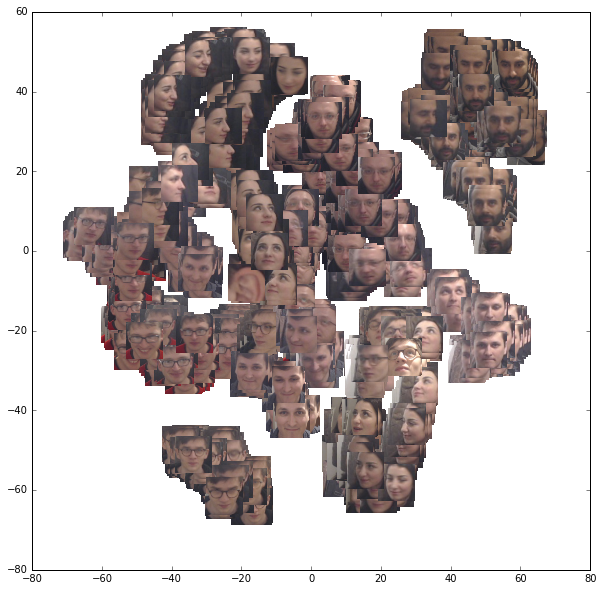

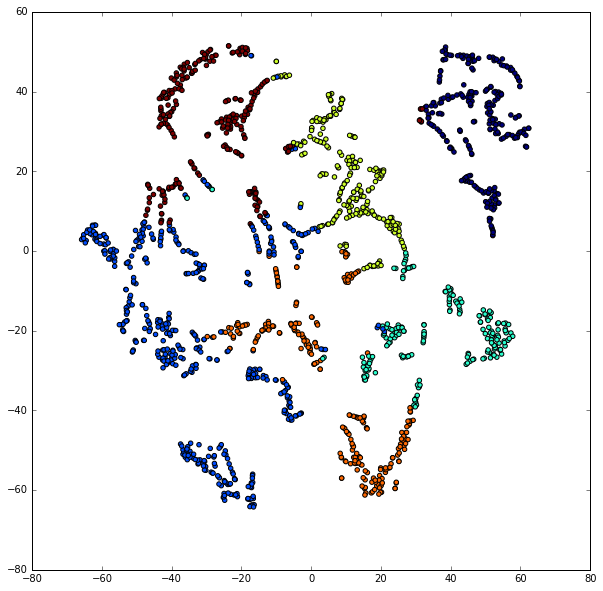

In [19]:
import cv2
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

X_embedded = TSNE(n_components=2, learning_rate=100, perplexity=20).fit_transform(representations) 
# not using all representations)

# plot embedding with image patches
fig,ax = plt.subplots(figsize=(10,10))
for idx,embed in enumerate(X_embedded):
    oi = OffsetImage(cv2.resize(images[idx],(246,246)), zoom = 0.15)
    box = AnnotationBbox(oi, (embed[0], embed[1]), frameon=False)
    ax.add_artist(box)
ax.plot(X_embedded[:,0], X_embedded[:,1], '.')
plt.show()

# plot embedding with colors (recognize overlaps better)
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=kmeans, cmap='jet')
plt.show()